In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab09.ipynb")

# Lab 09: Random Variables
In this lab, you will:

1. Explore properties of random variables using the example of a binomial distribution.
1. Verify the Central Limit Theorem (CLT) using simulations. 
1. Examine if the "sample maximum" is a biased estimator for the true maximum of a population.

### Due Date

The on-time deadline is **Tuesday, October 31st at 11:59 PM PT** (Happy Halloween!). Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted.

### Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

**Note**: The walkthrough video is partially recorded from Spring 2023. There may be slight inconsistencies between the version you are viewing and the version used in the recording, but content is identical.

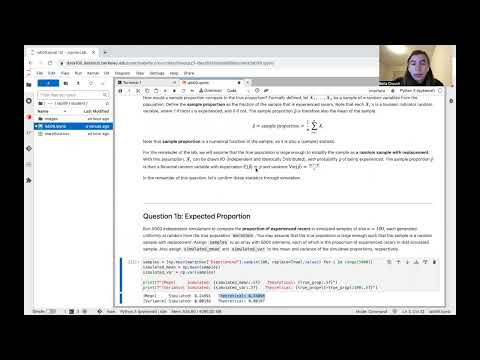

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("_K7OvmRbb5w")

### Collaboration Policy
Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

In [3]:
# Run this cell to set up your notebook
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from IPython.display import FileLink, FileLinks
FileLink('path_to_file/filename.extension')
%matplotlib inline
sns.set()
sns.set_context("talk")
import warnings
warnings.filterwarnings('ignore')

np.random.seed(2023) # Do not change this line; this sets the pseudorandomness of the autograder.

from IPython.display import display, Latex, Markdown

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Question 1: Probability with Binomial Random Variables

---

## Question 1a: Loading the Data

The Berkeley Half Marathon is an annual weekend-long race here in Berkeley. 

We want to understand how many participants in this year’s race also participated in the previous year's race. To accomplish this, we collect a sample of this year’s participants.

Let's first assume that we have access to the official data so we can simulate the potential result we might get (**in practice we don't!**). The dataset `marathon.csv` includes information for **all racers** who registered for the Berkeley Half Marathon. In other words, the dataset represents our **full population**.

* The `Bib Number` of each participant (i.e., racer) is in order of registration — integers from $1$ to the total unknown number of participants. 
* The column `Race Type` denotes the type of race a participant is in.
* The column `Experienced` denotes if a participant participated in the race in the previous year.
* The column `Dog Lover` denotes if a participant is a dog lover.

Load the dataset `marathon.csv` into the `DataFrame` `marathon` and assign `true_prop` to the true proportion of experienced racers. 

**Hint:** The **true proportion** of experienced racers is the proportion of experienced racers in the *population*. We term numerical functions of the population, such as the true proportion of experienced racers, as **population parameters**.

In [4]:
marathon = pd.read_csv("marathon.csv")
display(marathon.head())
true_prop = np.mean(marathon["Experienced"]==True)
print(f"The true proportion of experienced racers in the population of size {len(marathon)} is {np.round(true_prop, 4)}") 

,Bib Number,Race Type,Experienced,Dog Lover
0,1,10.0,False,False
1,2,5.0,False,False
2,3,1.0,False,False
3,4,10.0,False,True
4,5,10.0,False,False


The true proportion of experienced racers in the population of size 50732 is 0.249


In [5]:
grader.check("q1a")

q1a results: All test cases passed!

Suppose that you have access to the official roster and are able to collect a Simple Random Sample (SRS) of 100 racers. You decided to use the proportion of experienced racers in this smaller *sample* as an **estimate** of the true proportion of experienced racers in the full *population*. Let's denote this true proportion as $p$.


How would a sample proportion compare to the true proportion? Suppose we take a simple random sample of size $n$. For an individual $i \in \{1, 2, \dots, n\}$ in our sample, we define $X_i$ to be a random variable indicating if individual $i$ is experienced or not. That is, if individual $i$ is experienced, $X_i = 1$, otherwise, $X_i = 0$. Then we can define the sample proportion as the fraction of experienced racers in the sample. The sample proportion $\hat{p}$ is therefore also the mean of the sample.

$$\hat{p} = \text{sample proportion} = \frac{1}{n}\sum_{i=1}^{\text{n}} X_i$$

Note that **sample proportion** is a numerical function of the sample, so it is also a (sample) statistic. As a reminder, sample statistics are random variables, due to the randomness of the samples. 


For the remainder of the lab, we will assume that the true population is large enough to simplify the sample as **a random sample with replacement.** Under this assumption, $X_i$’s are i.i.d (independent and identically distributed). Each $X_i$ follows a Bernoulli distribution with probability $p$ that a racer is experienced (i.e. $P(X_i = 1) = p$). Then, the sample proportion $\hat{p}$ is a scaled Binomial random variable with expectation $\mathbb{E}[\hat{p}] = p$ and variance $\text{Var}(\hat{p}) = \frac{p(1-p)}{n}$.

As a reminder, we can show that $\mathbb{E}[\hat{p}] = p$ via linearity of expectation:

$$
\mathbb{E}[\hat{p}] = \mathbb{E}[\frac{1}{n}\sum_{i=1}^{\text{n}} X_i] = \frac{1}{n}\sum_{i=1}^{\text{n}} \mathbb{E}[X_i] = \frac{1}{n}\sum_{i=1}^{\text{n}} p = \frac{np}{n} = p
$$

and $\text{Var}(\hat{p}) = \frac{p(1-p)}{n}$ via additivity of variance in independent variables:

$$
\text{Var}(\hat{p}) = \text{Var}(\frac{1}{n}\sum_{i=1}^{\text{n}} X_i) = \frac{1}{n^2}\sum_{i=1}^{\text{n}} \text{Var}(X_i) = \frac{1}{n^2}\sum_{i=1}^{\text{n}} p(1-p) = \frac{p(1-p)}{n}
$$

In the remainder of this question, let's confirm these statistics through simulation.

<br><br>

---

## Question 1b: Expected Proportion

The expressions above give us the expectation and variance for the proportion of experienced racers if we apply probability theory. Do these results hold true if we actually simulate the proportion of experienced racers on random samples?”

Run 5000 independent simulations to compute the **proportion of experienced racers** in simulated samples of size $n = 100$, each generated uniformly at random from the true population `marathon`. You may assume that the true population is large enough such that the sample is a random sample with replacement. Assign `samples` to an array with 5000 elements, each of which is the proportion of experienced racers in that simulated sample. Also, assign `simulated_mean` and `simulated_var` to the mean and variance of the simulated proportions, respectively.

In [6]:
samples = [np.mean(marathon["Experienced"].sample(100, replace = True).values) for i in range(5000)]
simulated_mean = np.mean(samples)
simulated_var = np.var(samples)

print(f"[Mean]     Simulated: {simulated_mean:.5f}   Theoretical: {true_prop:.5f}")
print(f"[Variance] Simulated: {simulated_var:.5f}   Theoretical: {true_prop*(1-true_prop)/100:.5f}")

[Mean]     Simulated: 0.24991   Theoretical: 0.24898
[Variance] Simulated: 0.00189   Theoretical: 0.00187


In [7]:
grader.check("q1b")

q1b results: All test cases passed!

<br>

---

What is a better way to support racers than passing out dog photos? :-) You decide to take a sample of size $n = 100$, where each racer will receive 1 dog photo if they are an experienced racer, 3 dog photos if they love dogs, and 4 dog photos if they are both an experienced racer and love dogs. What is the expected number of photos you need to print? 

Again, assume that the true population is large enough such that the sample is a random sample with replacement to simplify the problem, and that whether a racer loves dogs and whether the racer participated in the previous year are independent. Let $D$ be the number of dog photos that need to be printed. Here, we picked $D$ to refer to **d**og photos. More generally, when picking letters for random variables, it is good practice to try and pick something informative and unambiguous. 

We can then find the **expected number of photos, $\mathbb{E}(D)$** as follows: 
$$\mathbb{E}(D) = \large 100 \cdot p + 100 \cdot 3 \cdot q,$$ 
where $p$ is the true proportion of experienced racers and $q$ is the true proportion of dog lovers. This result follows from the linearity of expectation:

$$\mathbb{E}[aX+bY] = a \mathbb{E}[X] + b\mathbb{E}[Y].$$

The variance of the number of photos is:
$$\text{Var} (D) = \large 100 \cdot p (1- p)+ 100 \cdot 3^2 \cdot q (1- q),$$
which follows from the properties of variance and that the two samples are independent: 

$$\text{Var}(aX+bY) = a^2\text{Var}(X) + b^2\text{Var}(Y) + 2 \cdot a \cdot b \text{Cov}(X, Y) = a^2\text{Var}(X) + b^2\text{Var}(Y).$$

See the video walkthrough for a full derivation of these results.

<br>

---

## Question 1c: Expectation and Variance of Linear Combinations of Random Variables

Confirm this result through simulation. Run 5000 independent simulations, where each simulation finds the number of **photos** needed for a sample of size $n = 100$ racers, selected uniformly at random (with replacement) from the true population `marathon`.  Assign `photo_samples` to an array with 5000 elements, each of which is the number of **photos** needed for the simulated sample. 

**Note:** We have computed `prop_dog_lover`, the true proportion of dog lover racers for you so that you can verify that your simulated statistics match the theoretical statistics.

In [8]:
prop_dog_lover = np.mean(marathon["Dog Lover"])

photo_samples = []
for i in range(5000):
    sample = marathon.sample(100, replace = True)
    n_photos = 1*np.sum(sample["Experienced"]) + 3*np.sum(sample["Dog Lover"])
    photo_samples.append(n_photos)

simulated_photos_mean = np.mean(photo_samples)
simulated_photos_var = np.var(photo_samples)


print(f"[Mean]     Simulated: {simulated_photos_mean:.5f}    Theoretical: {(true_prop + 3*prop_dog_lover)*100:.5f}")
print(f"[Variance] Simulated: {simulated_photos_var:.5f}   Theoretical: {100*true_prop*(1-true_prop) + 900*prop_dog_lover*(1-prop_dog_lover):.5f}")

[Mean]     Simulated: 84.80600    Theoretical: 84.77687
[Variance] Simulated: 165.43756   Theoretical: 162.48136


In [9]:
grader.check("q1c")

q1c results: All test cases passed!

<br>
<hr style="border: 1px solid #fdb515;" />

# Question 2: Central Limit Theorem

The Central Limit Theorem states that the distribution of the sample mean will converge to a normal distribution as the sample size ($n$) goes to infinity. That means that if we collected enough samples from the population, calculated the proportion of experienced racers (which is a sample mean) for each sample, and viewed a histogram of the proportions, we would see a normal distribution!

Let's see this in action!

<br>

---

## Question 2a
Complete the function `simulate`. The function `simulate` takes in one argument (`sample_size`: the size of the sample) and returns a list of length 5000 where each element is the proportion of experienced racers in a random sample of size `sample_size`. 

Then, use `simulate` to run 5000 independent simulations, where each simulation finds the proportion of **experienced racers** in a sample of size of 100, 500, and 1000 selected uniformly at random from the true population `marathon`. You may assume that the true population is large enough such that the sample is a random sample with replacement (note that in reality, our population is finite in size about 50k; this approximation becomes more inaccurate as our sample size grows larger). You should assign `samples100`, `samples500`, and `samples1000` each to arrays of 5000 elements with proportions of experienced racers of sample sizes **100**, **500**, and **1000**, respectively.

In [10]:
def simulate(sample_size):
    return [np.mean(marathon["Experienced"].sample(sample_size, replace = True).values) for i in range(5000)]

samples100 = simulate(100)
samples500 = simulate(500)
samples1000 = simulate(1000)

In [11]:
grader.check("q2a")

q2a results: All test cases passed!

<br>

---

## Question 2b

Recall that if a random variable follows a normal distribution with mean $\mu$ and variance $\sigma^2$, then its Probability Density Function (pdf) is
$$\large
f(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2  \sigma ^2} \right)
$$

Complete the function `gaussian` which returns the pdf of a normal distribution with mean `mean`, and variance of `var`, computed at values `x`. Pay attention to the order of operations and add parentheses accordingly - the solution presented in the lab walkthrough video is missing a pair, so you will need to modify the solution slightly!

**Hint:** This is very similar to `gaussian_kernel` from Lab 04!

In [12]:
def gaussian(mu, var, x):
    """
    Compute the Gaussian density at value x.

    Args:
        mu: the mean/center of the Gaussian distribution.
        var: variance of the Gaussian distribution.
        x: observation.

    Returns:
        The density at value x.
    """    
    return (1/np.sqrt(2*np.pi*var)*np.exp(-1*(x-mu)**2/(2*var)))

gaussian(0, 1, np.array([-1, 0, 1]))

array([0.24197072, 0.39894228, 0.24197072])

In [13]:
grader.check("q2b")

q2b results: All test cases passed!

<br>

---

## Question 2c

We are ready to demonstrate the Central Limit Theorem visually by comparing simulated distributions of sample means to the normal distribution. We have provided the skeleton code of an interactive plot. Fill in the blanks below using the `simulate` and `gaussian` functions from previous parts of this question.

Then, in the cell below, describe the mean and spread of the sampling distribution and how they change as you increase the value of `sample_size`.

In [14]:
from ipywidgets import interact

def f(sample_size):
    plt.figure(figsize=(10, 5))
    # Generate the simulated proportions
    sim_samples = simulate(sample_size)
    # Make a histogram plot of the simulated proportions. Set density to True and edgecolor to "none"
    plt.hist(sim_samples, density = True, edgecolor = "none")
    x = np.linspace(0, 1, 1001)
    # We provided the mean and variance for you. If you are interested in knowing how to calculate these, take Data 140!
    mean = true_prop
    var = true_prop*(1-true_prop)/sample_size
    # Compute the pdf of the normal distribution of mean `mean` and variance `var` at locations x
    y = gaussian(mean, var, x)
    plt.plot(x, y, linewidth=1)
    plt.xlim(0, 0.6);
    plt.ylim(0, 35);
    plt.show()
interact(f, sample_size=(10, 1000, 10));

interactive(children=(IntSlider(value=500, description='sample_size', max=1000, min=10, step=10), Output()), _…

_The mean seems to be around 0.25, as it is a normal Gaussian distribution and that is the center of the histogram. The spread seems to be generally decent, at about 0.05 for two-ish standard deviations. As you increase the value of sample_size, the spread decreases and there is more density under the mean and the values are more scrunched up around that sample mean value. As you increase the sample_size, the variance also decreases. As you increases sample_size, the distribution more closely follows a normal distribution._

<!-- END QUESTION -->

<br>

<hr style="border: 1px solid #fdb515;" />

# Question 3: Estimator for Population Max


Now suppose that we do not have access to the official roster; instead, we only have one sample. Without the official roster, we do not know the population and therefore do not know the total number of racers. However, we still want to estimate the total racers given an observed sample so we can prepare a dog photo for everyone. That is, we want to find an estimator for the **population maximum**.

Recall that the `Bib Number` of each participant (i.e., racer) is in order of registration—integers from $1$ to the total unknown number of participants. You decide to construct a sample by recording the bib number of every racer you see on the street in a given time period and use the maximum bib number in your sample as an estimator for the true maximum bib number (that is, the total number of participants, assuming everyone who registered participated). Assume that a racer's bib number has no relation to their racing experience so that you are equally likely to see any of the bib numbers in your sample.

**Is the sample maximum a good estimator for the population maximum?** We'll use simulation to explore the answer to this question in this part of the lab.

<br>

---

## Question 3a

Let's first assume that we have access to the total number of participants (again, in practice we don't!). Find the **true population maximum** and assign it to `true_max`.

In [26]:
true_max = max(marathon["Bib Number"])
true_max

50732

In [27]:
grader.check("q3a")

q3a results: All test cases passed!

In [28]:
# Run this cell to see the summary statistics of Bib Number; no further action is needed.
marathon.describe()

,Bib Number,Race Type
count,50732.000000,50732.000000
mean,25366.500000,13.223222
std,14645.211265,7.312977
min,1.000000,1.000000
25%,12683.750000,10.000000
50%,25366.500000,10.000000
75%,38049.250000,21.100000
max,50732.000000,21.100000


You can use the above output to quickly check and see if the value you assigned to `true_max` aligns with what you find in the dataset.

<br>

---

## Question 3b

How would a sample maximum compare to the true maximum? Suppose we draw a sample of size $n$ with replacement from the population. We denote the bib number of individual $i$ in the sample as $B_i$. We will have $n$ i.i.d. random variables: $B_1, B_2, \dots, B_n$. Define the **sample max** as the maximum value of the sample.

$$\text{sample max} = \max (B_1, \dots, B_n)$$


Recall from [Data 8](https://inferentialthinking.com/chapters/10/3/Empirical_Distribution_of_a_Statistic.html) that we can get the empirical distribution of a statistic by **simulating**, or repeatedly sampling from the population.
Suppose we compute the sample max as the **maximum bib number from observing the bib numbers of $n = 200$ random racers**. By repeating this process for many randomly selected samples, we get a simulated distribution of the sample max statistic.

Assign `sample_maxes` to an array that contains 5000 simulated sample maxes from samples of size $n = 200$, each sampled randomly **with replacement** from the population `marathon`. (Side note: We sample with replacement because while it suggests that we could see the same racer multiple times in our sample, it allows us to assume each individual in our sample is drawn i.i.d. from the population.)

Some useful functions: `df.sample` ([link](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html)), `np.random.choice` ([link](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)). 



In [31]:
sample_maxes = []
for i in range(5000):
    sample = marathon["Bib Number"].sample(200, replace = True)
    sample_maxes.append(max(sample))

In [32]:
grader.check("q3b")

q3b results: All test cases passed!

<br>

---


## Question 3c

Plot the empirical distribution of the sample maximum that you generated in Question 3b. Your plot should look like the below plot. It should include both the average sample maximum and the true population maximum as vertical lines.

<img src='images/sample_max_dist.png' width="600px" />

Visualization/plotting tips:
* To plot a vertical line with specific linestyles, see the `plt.axvline` [documentation](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.axvline.html).
* To include a label in the legend, pass in `label=...` to the plot that you'd like to label ([example](https://matplotlib.org/3.5.1/gallery/pyplots/axline.html#sphx-glr-gallery-pyplots-axline-py)).


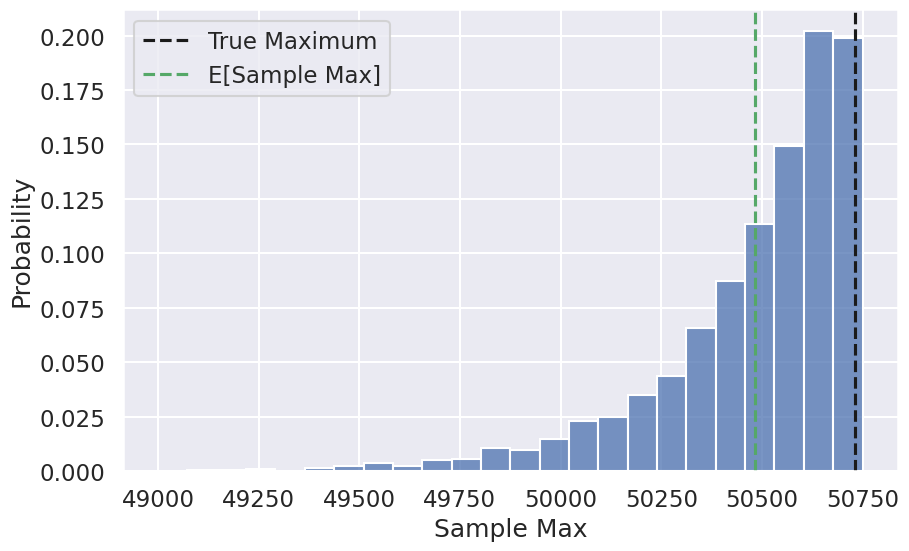

In [38]:
plt.figure(figsize = [10, 6])
bins = np.linspace(49000, 50750, 25) # For your plot

avg_sample_maxes = np.mean(sample_maxes)
sns.histplot(sample_maxes, stat = 'probability', bins=bins)
plt.xlabel("Sample Max")
plt.axvline(x = true_max, color = 'k', linestyle = '--', label = 'True Maximum');
plt.axvline(x = avg_sample_maxes, color = 'g', linestyle = '--', label = 'E[Sample Max]');

plt.legend();     # Show legend

</br>

---

### Question 3d

Recall from Lecture 16 that an **unbiased estimator** is one where the expected value of the estimator is the parameter. For example, the sample mean $\bar{X}_n$ is an unbiased estimator of the population mean $\mu$ because $\mathbb{E}[\bar{X}_n] = \mu$ by linearity of expectation.

Based on your analysis in Question 3c, assign `q3d` to the most correct option out of the following; then in the second cell, **explain your choice.**

1. The sample maximum is an unbiased estimator of the population maximum.
1. The sample maximum overestimates the population maximum.
1. The sample maximum underestimates the population maximum.


_Type your answer here, replacing this text._

In [39]:
q3d = 3

In [40]:
grader.check("q3d")

q3d results: All test cases passed!

<br>

## Food for thought (optional):

What if instead of the sample max, we use another estimator, $2 \bar{X_n} - 1$?  This is a common approach for this kind of uniform data; if you are interested, simulate and visualize the results for this estimator.

In [23]:
# your optional visualization here

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Congratulations! You are finished with Lab 09!

Here at Data 100, we believe everyone deserves dog photos, even if you haven't run the Berkeley Half Marathon. We added in a couple extra to make up for the profound lack of dog photos at the end of A2. Here's a collage of Roxy, Ludo, and Nori!

<img src='images/roxy_1.jpeg' width="280px" /> <img src='images/roxy_2.jpeg' width="245px" /> 

<img src='images/ludo_1.jpeg' width="200px" /> <img src='images/ludo_2.jpeg' width="200px" />

<img src='images/Nori_1.jpg' width="190px" /> <img src='images/Nori_2.jpg' width="399px" />

<img src='images/Nori_3.jpg' width="270px" /> <img src='images/Nori_4.jpg' width="162px" />


## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [24]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q1a results: All test cases passed!

    q1b results: All test cases passed!

    q1c results: All test cases passed!

    q2a results: All test cases passed!

    q2b results: All test cases passed!

    q3a results:
        q3a - 1 result:
            ❌ Test case failed
            Trying:
                true_max == 50732
            Expecting:
                True
            **********************************************************************
            Line 1, in q3a 0
            Failed example:
                true_max == 50732
            Expected:
                True
            Got:
                False

    q3b results:
        q3b - 1 result:
            ❌ Test case failed
            Trying:
                len(sample_maxes) == 5000
            Expecting:
                True
            ************************************